In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightning import seed_everything

from htc.cpp import map_label_image
from htc.fonts.set_font import set_font
from htc.model_processing.SinglePredictor import SinglePredictor
from htc.models.common.utils import sample_to_batch
from htc.models.image.DatasetImage import DatasetImage
from htc.settings import settings
from htc.settings_seg import settings_seg
from htc.tivita.DataPath import DataPath
from htc.utils.Config import Config
from htc_projects.context.context_transforms import OrganIsolation, OrganRemoval
from htc_projects.context.models.context_evaluation import context_evaluation_table, glove_runs
from htc_projects.context.settings_context import settings_context

set_font()

In [2]:
run_context = settings_context.best_transform_runs["organ_transplantation"]
df1 = context_evaluation_table(run_context, test=True, aggregate=False)
df2 = glove_runs(
    {
        "baseline": settings_context.glove_runs["baseline"],
        "organ_transplantation": settings_context.glove_runs["organ_transplantation"],
    },
    aggregate=False,
)
df = pd.concat([df1, df2])
df.replace({"network": {"context": "organ_transplantation"}}, inplace=True)
df.head()

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/image/2022-02-03_22-58-44_generated_default_model_comparison                 

,ce_loss,ece,dice_metric,used_labels,dice_metric_image,confusion_matrix,surface_distance_metric,surface_distance_metric_image,surface_dice_metric_mean,surface_dice_metric_image_mean,image_name,network,dataset,dataset_index,subject_name,timestamp
0,2.040663,"{'error': 0.8628411889076233, 'accuracies': [1...","[0.9966934, 0.97932774, 0.9884513, 0.99261785,...","[0, 3, 4, 5, 9]",0.986499,"[[146642, 0, 2, 23, 315, 483, 0, 0, 0, 65, 0, ...","[0.30972793166884083, 0.5907705154388064, 1.14...",0.757825,"[0.9855702364394993, 0.8432470258922323, 0.986...",0.929099,P043#2019_12_20_10_05_27,baseline,semantic,NaN,NaN,NaN
1,2.040144,"{'error': 0.8638126254081726, 'accuracies': [1...","[0.99715513, 0.9796044, 0.9904817, 0.9939147, ...","[0, 3, 4, 5, 9]",0.987200,"[[145637, 0, 0, 27, 222, 465, 0, 0, 0, 41, 0, ...","[0.26621675778031273, 0.6333655949351811, 0.94...",0.678203,"[0.9952887803175711, 0.8712871287128713, 0.995...",0.924438,P043#2019_12_20_10_05_48,baseline,semantic,NaN,NaN,NaN
2,2.038484,"{'error': 0.8648071885108948, 'accuracies': [1...","[0.9983746, 0.9917354, 0.9931921, 0.9908809, 0...","[0, 3, 4, 5, 8]",0.906800,"[[180891, 0, 0, 333, 37, 64, 0, 0, 0, 0, 0, 0,...","[0.2174811256048084, 1.200060671473143, 0.3961...",1.401052,"[0.9935509087355873, 0.7235883424408015, 0.999...",0.795433,P043#2019_12_20_10_06_32,baseline,semantic,NaN,NaN,NaN
3,2.041420,"{'error': 0.8622098565101624, 'accuracies': [1...","[0.995851, 0.9913923, 0.9891495, 0.9930062, 0.0]","[0, 3, 4, 5, 8]",0.793880,"[[99849, 0, 0, 330, 141, 254, 0, 0, 0, 0, 0, 0...","[0.2822919895982137, 3.982988025147015, 1.0842...",2.028823,"[0.9896065330363771, 0.7454203851573509, 0.996...",0.727201,P043#2019_12_20_10_07_03,baseline,semantic,NaN,NaN,NaN
4,2.041602,"{'error': 0.8628288507461548, 'accuracies': [1...","[0.995935, 0.9920827, 0.9908885, 0.99351233, 0.0]","[0, 3, 4, 5, 8]",0.794484,"[[99594, 0, 0, 256, 183, 303, 0, 0, 0, 0, 0, 0...","[0.27734278592477596, 3.6474446861401466, 0.92...",1.854296,"[0.9873793615441723, 0.7827311121539183, 1.0, ...",0.734515,P043#2019_12_20_10_07_28,baseline,semantic,NaN,NaN,NaN


In [3]:
networks = {
    "baseline": SinglePredictor(
        model="image",
        run_folder=f"{settings_seg.model_comparison_timestamp}_generated_default_model_comparison",
        test=True,
    ),
    "organ_transplantation": SinglePredictor(path=run_context, test=True),
    "baseline_occlusions": SinglePredictor(path=settings_context.glove_runs["baseline"], test=True),
    "organ_transplantation_occlusions": SinglePredictor(
        path=settings_context.glove_runs["organ_transplantation"], test=True
    ),
}

Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.3.2. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint ../../../../../../mnt/ssd_8tb/htc/results_semantic/training/image/2022-02-03_22-58-44_generated_default_model_comparison/fold_P041,P060,P069/epoch=46-dice_metric=0.87.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.3.2. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint ../../../../../../mnt/ssd_8tb/htc/results_semantic/training/image/2022-02-03_22-58-44_generated_default_model_comparison/fold_P044,P050,P059/epoch=70-dice_metric=0.90.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.3.2. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint ../../../../../../mnt/ssd_8tb/htc/results_semantic/training/image/2022-02-03_22-58-44_g

Seed set to 42


P043#2019_12_20_10_10_19
isolated label: stomach
P072#2020_08_08_13_14_14
isolated label: stomach
P042#2019_12_15_11_15_55@semantic#annotator5
P043#2019_12_20_10_11_20
most important neighbour of stomach is liver
P043#2019_12_20_10_11_20
most important neighbour of stomach is liver
P062#2020_05_15_18_46_30


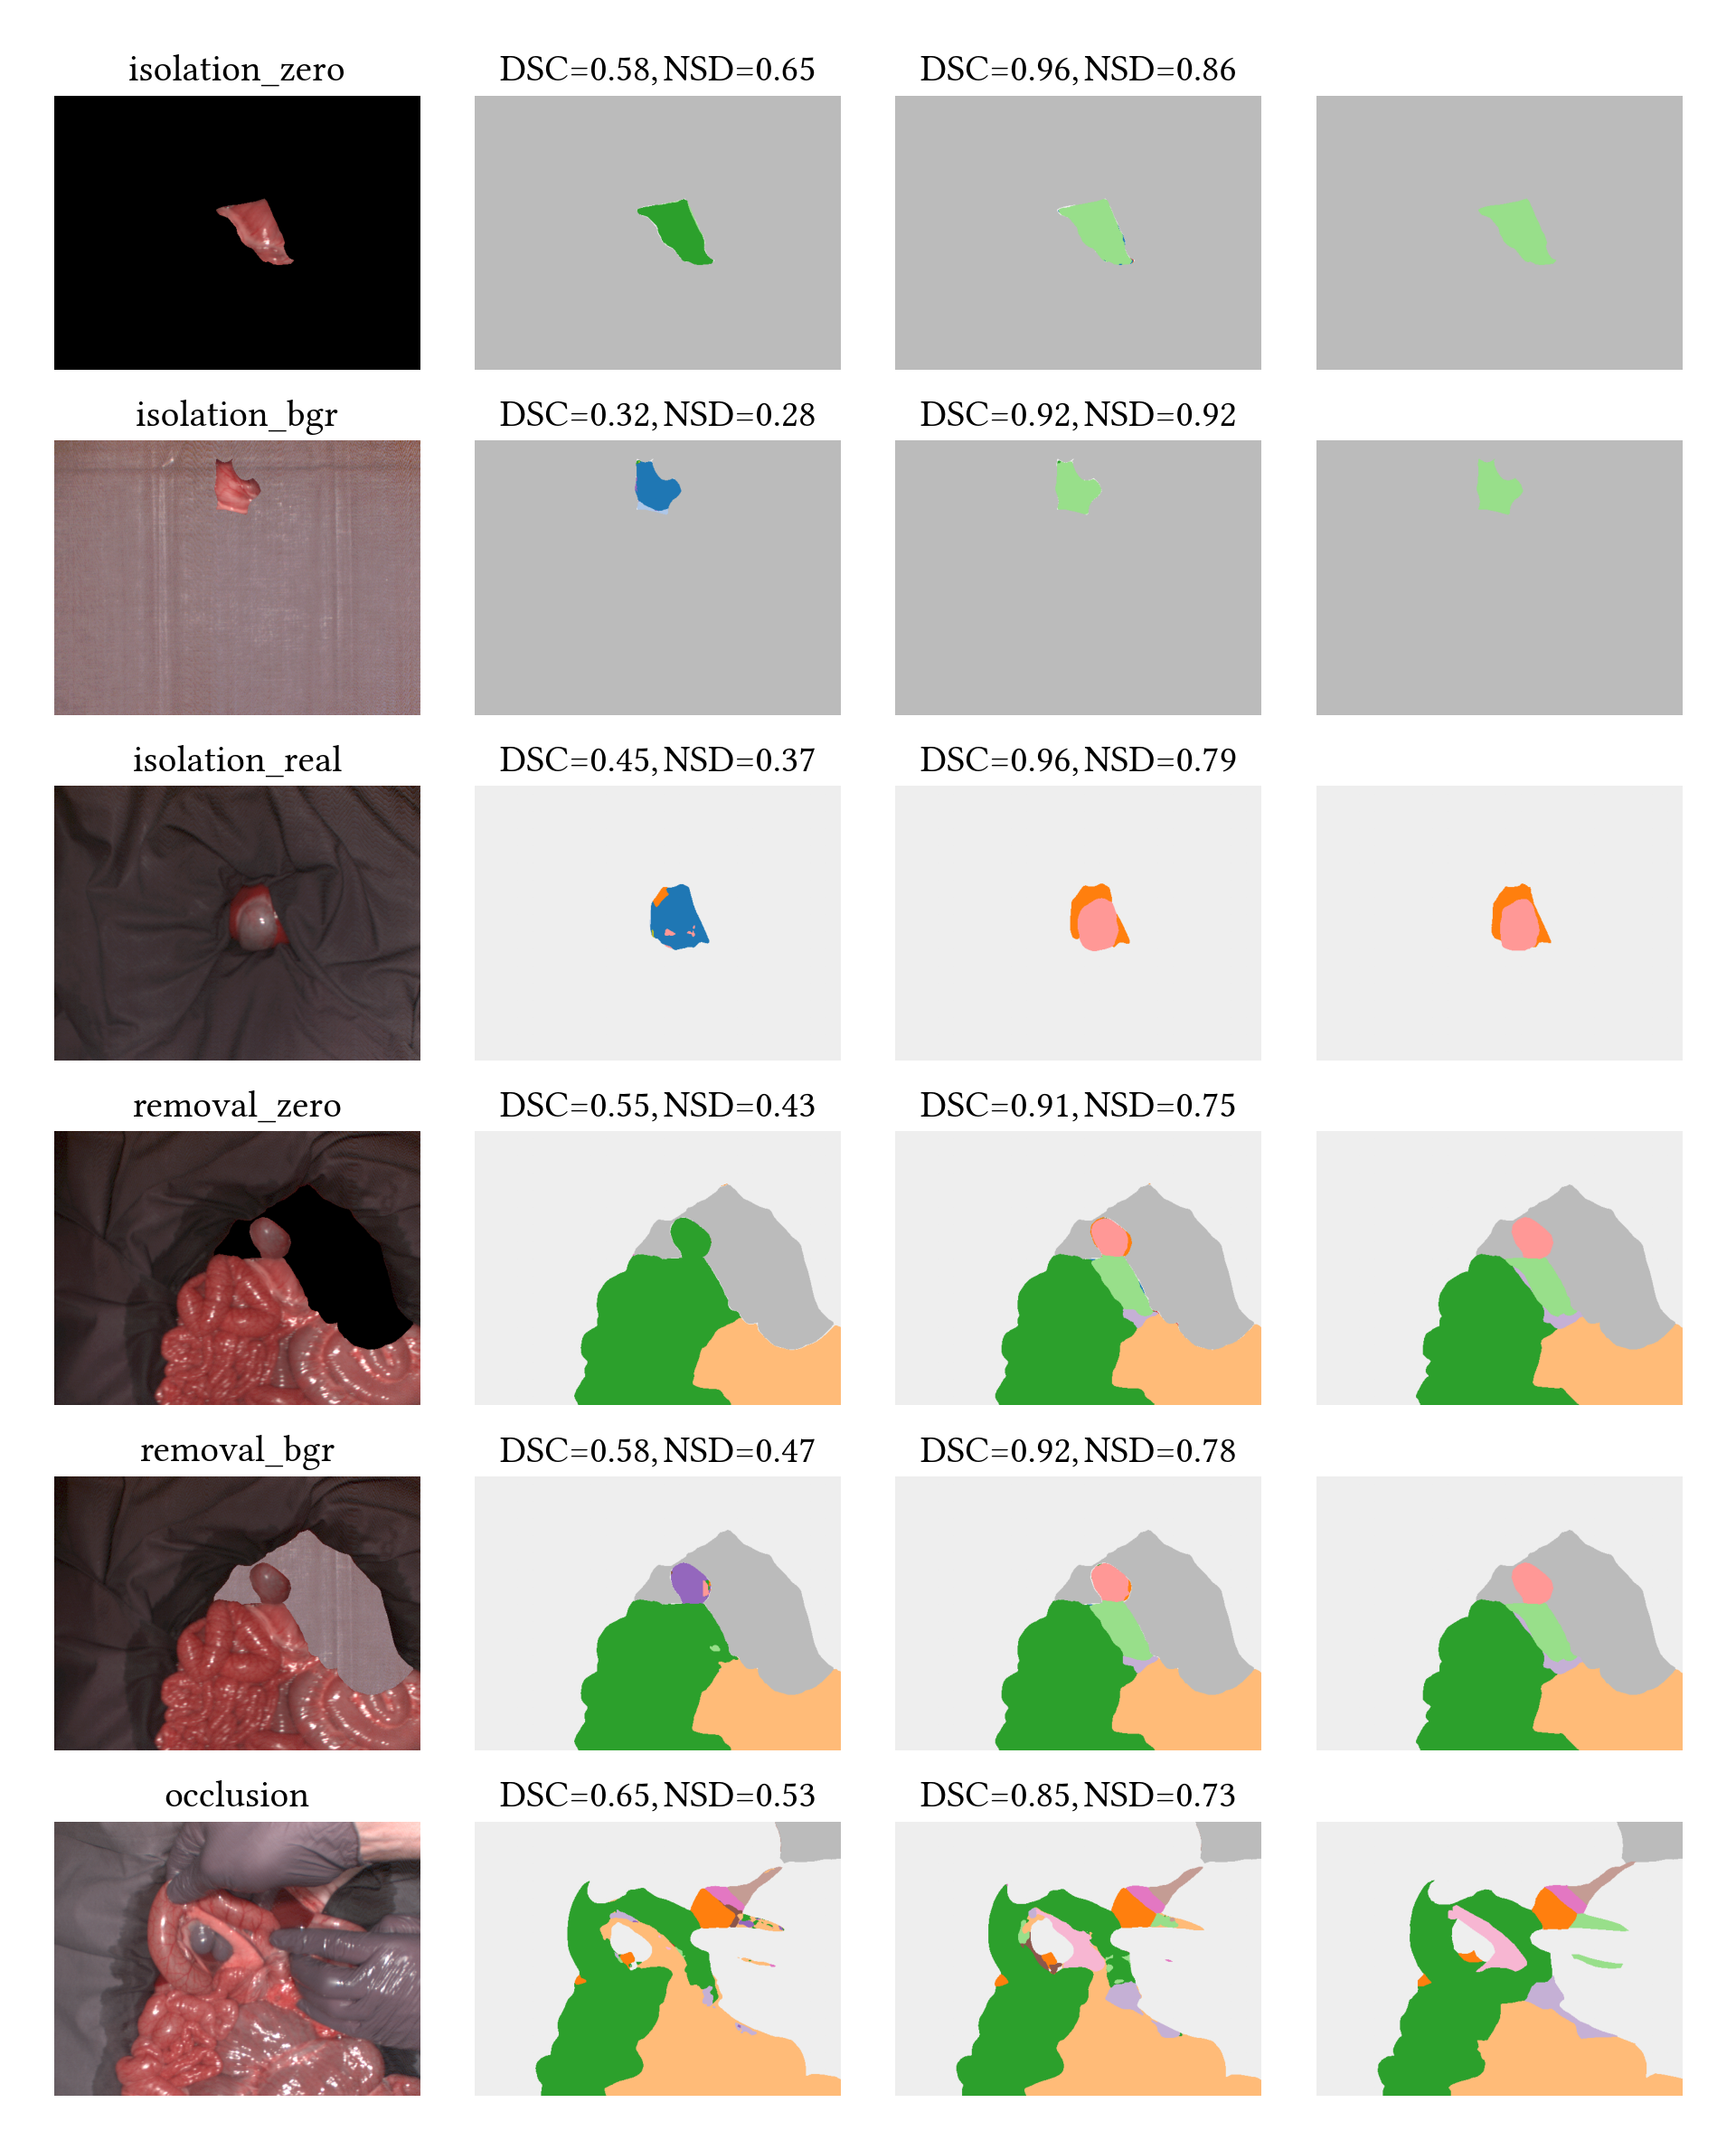

In [4]:
seed_everything(42)
datasets = ["isolation_0", "isolation_cloth", "masks_isolation", "removal_0", "removal_cloth", "glove"]
label_mapping = settings_seg.label_mapping
label_mapping.label_colors = settings_seg.label_colors_paper

config_rgb_base = Config({"input": {"preprocessing": None, "n_channels": 3}})

fig, axes = plt.subplots(len(datasets), 4, figsize=(3, 5), dpi=600)
fig.subplots_adjust(hspace=-0.65, wspace=0.15, left=0, right=1, bottom=0, top=1)

for i, dataset in enumerate(datasets):
    # Image-level scores for each network
    df_dataset = df.query("dataset == @dataset")
    df_baseline = df_dataset.query("network == 'baseline'")
    df_context = df_dataset.query("network == 'organ_transplantation'")
    assert (df_baseline["image_name"] == df_context["image_name"]).all()
    assert np.all([
        np.all(row1 == row2) for row1, row2 in zip(df_baseline["used_labels"], df_context["used_labels"], strict=True)
    ])

    # Find the image with the highest difference in dice_metric_image
    df_diff = pd.DataFrame({
        "image_name": df_baseline["image_name"],
        "used_labels": df_baseline["used_labels"],
        "dice_metric_image_baseline": df_baseline["dice_metric"].apply(np.mean),
        "dice_metric_image_context": df_context["dice_metric"].apply(np.mean),
        f"{settings_seg.nsd_aggregation_short}_baseline": df_baseline[settings_seg.nsd_aggregation_short].apply(
            np.mean
        ),
        f"{settings_seg.nsd_aggregation_short}_context": df_context[settings_seg.nsd_aggregation_short].apply(np.mean),
        "diff_image": df_context["dice_metric"].apply(np.mean) - df_baseline["dice_metric"].apply(np.mean),
        "diff_classes": df_context["dice_metric"].apply(np.asarray) - df_baseline["dice_metric"].apply(np.asarray),
    })
    df_diff.sort_values("diff_image", ascending=False, inplace=True)
    selected = df_diff.iloc[0]
    selected_image_name = selected.image_name
    if dataset == "masks_isolation":
        selected_image_name = f"{selected_image_name}@semantic#annotator5"
    print(selected_image_name)

    network_suffix = "_occlusions" if dataset == "glove" else ""
    network_baseline = networks[f"baseline{network_suffix}"]
    network_context = networks[f"organ_transplantation{network_suffix}"]

    path = DataPath.from_image_name(selected_image_name)
    config_rgb = network_baseline.config.merge(config_rgb_base)
    sample_hsi = DatasetImage([path], train=False, config=network_baseline.config)[0]
    sample_rgb = DatasetImage([path], train=False, config=config_rgb)[0]

    # The label with the highest difference between baseline and context networks
    best_label = selected.used_labels[np.argmax(selected.diff_classes)]
    if dataset.startswith("isolation"):
        print(f"isolated label: {label_mapping.index_to_name(best_label)}")
        fill_value = dataset.split("_")[1]
        sample_hsi = sample_to_batch(
            OrganIsolation(fill_value=fill_value, target_label=best_label, config=network_baseline.config)
        )(sample_hsi)
        sample_rgb = sample_to_batch(OrganIsolation(fill_value=fill_value, target_label=best_label, config=config_rgb))(
            sample_rgb
        )
    elif dataset.startswith("removal"):
        # The removal case is a bit more complex because we do not want to remove the best label itself but its most important neighbour
        df_baseline_removal = pd.read_pickle(
            settings.results_dir
            / "neighbour_analysis"
            / f"organ_{dataset}"
            / "image"
            / f"{settings_seg.model_comparison_timestamp}_generated_default_model_comparison"
            / f"test_table_{dataset}.pkl.xz"
        )
        df_baseline_removal = df_baseline_removal.explode(["used_labels", "dice_metric"])
        df_baseline_removal = df_baseline_removal.query(
            "image_name == @selected_image_name and used_labels == @best_label"
        )
        df_baseline_removal.sort_values("dice_metric", ascending=True, inplace=True)  # Lowest score on top
        target_label = df_baseline_removal.iloc[0].target_label.item()
        assert target_label != best_label, f"target_label={target_label}, best_label={best_label}"

        print(
            f"most important neighbour of {label_mapping.index_to_name(best_label)} is"
            f" {label_mapping.index_to_name(target_label)}"
        )
        fill_value = dataset.split("_")[1]
        sample_hsi = sample_to_batch(
            OrganRemoval(fill_value=fill_value, target_label=target_label, config=network_baseline.config)
        )(sample_hsi)
        sample_rgb = sample_to_batch(OrganRemoval(fill_value=fill_value, target_label=target_label, config=config_rgb))(
            sample_rgb
        )

    rgb = sample_rgb["features"].numpy()
    rgb = (rgb * 255).astype(np.uint8)

    axes[i, 0].imshow(rgb, origin="lower")
    axes[i, 0].axis("off")
    axes[i, 0].set_title(settings_context.task_name_mapping[dataset], fontsize=5, y=0.89)

    res_baseline = network_baseline.predict_sample(sample_hsi["features"])["class"].cpu().argmax(dim=0)
    res_baseline[~sample_hsi["valid_pixels"]] = settings.label_index_thresh
    res_context = network_context.predict_sample(sample_hsi["features"])["class"].cpu().argmax(dim=0)
    res_context[~sample_hsi["valid_pixels"]] = settings.label_index_thresh
    seg_baseline = map_label_image(res_baseline, label_mapping)
    seg_context = map_label_image(res_context, label_mapping)
    seg_reference = map_label_image(sample_hsi["labels"], label_mapping)

    axes[i, 1].imshow(seg_baseline, origin="lower")
    axes[i, 1].axis("off")
    axes[i, 1].set_title(
        f"DSC={selected.dice_metric_image_baseline:.02f}, NSD={selected[f'{settings_seg.nsd_aggregation_short}_baseline']:.02f}",
        fontsize=5,
        y=0.89,
    )
    axes[i, 2].imshow(seg_context, origin="lower")
    axes[i, 2].axis("off")
    axes[i, 2].set_title(
        f"DSC={selected.dice_metric_image_context:.02f}, NSD={selected[f'{settings_seg.nsd_aggregation_short}_context']:.02f}",
        fontsize=5,
        y=0.89,
    )
    axes[i, 3].imshow(seg_reference, origin="lower")
    axes[i, 3].axis("off")

for ax in axes.flatten():
    ax.invert_yaxis()

fig.savefig(settings_context.paper_extended_dir / "example_predictions_base.pdf")

In [5]:
for image_name, network_suffix in [("P072#2020_08_08_13_03_28", ""), ("P072#2020_08_08_12_58_10", "_occlusions")]:
    path = DataPath.from_image_name(image_name)
    network_baseline = networks[f"baseline{network_suffix}"]
    network_context = networks[f"organ_transplantation{network_suffix}"]

    sample_hsi = DatasetImage([path], train=False, config=network_baseline.config)[0]

    res_baseline = network_baseline.predict_sample(sample_hsi["features"])["class"].cpu().argmax(dim=0)
    res_baseline[~sample_hsi["valid_pixels"]] = settings.label_index_thresh
    res_context = network_context.predict_sample(sample_hsi["features"])["class"].cpu().argmax(dim=0)
    res_context[~sample_hsi["valid_pixels"]] = settings.label_index_thresh
    seg_baseline = map_label_image(res_baseline, label_mapping)
    seg_context = map_label_image(res_context, label_mapping)
    seg_reference = map_label_image(sample_hsi["labels"], label_mapping)

    plt.imsave(
        settings_context.paper_extended_dir / f"example_prediction_rgb{network_suffix}.png",
        path.read_rgb_reconstructed(),
    )
    plt.imsave(
        settings_context.paper_extended_dir / f"example_prediction_baseline{network_suffix}.png", seg_baseline.numpy()
    )
    plt.imsave(
        settings_context.paper_extended_dir / f"example_prediction_organ_transplantation{network_suffix}.png",
        seg_context.numpy(),
    )

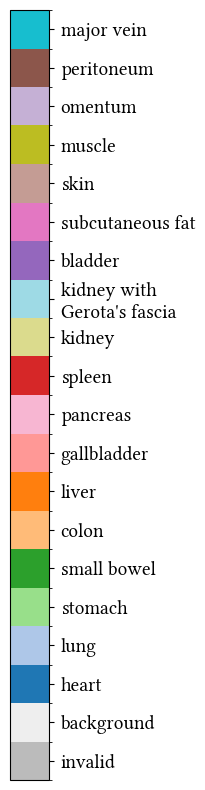

In [6]:
# Colorbar based on the label names/colors
cmap = mpl.colors.ListedColormap(list(settings_seg.label_colors_paper.values()))
bounds = list(range(len(settings_seg.label_colors_paper)))
bounds.append(max(bounds) + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(0.5, 10), dpi=100)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax)

tick_names = [settings_context.labels_paper_renaming.get(l, l) for l in settings_seg.label_colors_paper.keys()]
tick_names = [l.replace("<br>", "\n") for l in tick_names]

# We want the ticks to be placed in the middle of the box
r = cbar.vmax - cbar.vmin
cbar.set_ticks([cbar.vmin + r / len(tick_names) * (0.5 + i) for i in range(len(tick_names))])
cbar.ax.set_yticklabels(tick_names)
cbar.ax.tick_params(pad=5)

fig.savefig(settings_context.paper_extended_dir / "image_examples_cbar.pdf", bbox_inches="tight")